In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input , Concatenate
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers import *
from keras.initializers import he_normal
from keras.regularizers import l2
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.optimizers import *
from keras.utils import to_categorical
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
im_width = 128
im_height = 128
border = 5
im_chan = 3
n_features = 1 
path_train = 'data/train/'
path_test = 'data/test/'

In [3]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [4]:
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
sum_whites = 0
for n, id_ in enumerate(train_ids):
    path = path_train
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,:]
    x = resize(x, (im_height, im_width, im_chan), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,:]
    Y_train[n] = resize(mask, (im_height, im_width, 1), mode='constant', preserve_range=True)
    sum_whites += np.sum(Y_train[n])

print('Done!')

print("Salt in the dataset is {}".format(sum_whites*1.0 / (X_train.shape[0] * 128*128)))

Getting and resizing train images and masks ... 
Done!
Salt in the dataset is 0.24407986450195313


In [5]:
X_train.shape
Y_train.shape

(4000, 128, 128, 1)

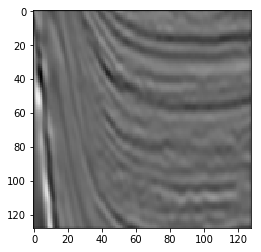

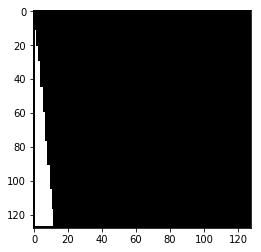

In [6]:
ix = random.randint(0, len(train_ids))
plt.imshow(X_train[ix])
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [7]:
X_train , X_val , Y_train , Y_val = train_test_split(X_train , Y_train , train_size = 0.9 , random_state = 2019)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
image_generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip = True,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2
)

mask_generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip = True,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2
)

val_image_generator = ImageDataGenerator(
)
val_mask_generator = ImageDataGenerator(
)

train_img_gen = image_generator.flow(X_train , seed = 2018 , batch_size = 16)
train_mask_gen = mask_generator.flow(Y_train , seed = 2018 , batch_size = 16)

val_img_gen = val_image_generator.flow(X_val , seed = 2018 , batch_size = 16)
val_mask_gen = val_mask_generator.flow(Y_val , seed = 2018 , batch_size = 16)

In [9]:
train_gen = zip(train_img_gen , train_mask_gen)
val_gen = zip(val_img_gen , val_mask_gen)

In [10]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [11]:
growth_rate = 8

In [12]:
def conv_block(inputs):
    
    X = BatchNormalization()(inputs)
    X = Activation('relu')(X)
    X = Conv2D(filters = growth_rate , kernel_size = 3 , kernel_initializer = he_normal(2019) , strides = 1 , padding = 'same')(X)
    X = Dropout(0.2)(X)
    
    return X

In [13]:
def dense_block(inputs , n_layers):
    
    layers = []
  
    identity = inputs
  
    for i in range(n_layers):
    
        X = conv_block(identity)
        layers.append(X)
        if(i != n_layers - 1):
            X = Concatenate()([X , identity])
            identity = X
    
    output = Concatenate()(layers)
  
    return output

In [14]:
def transition_down(inputs , filters):
    
    X = BatchNormalization()(inputs)
    X = Activation('relu')(X)
    X = Conv2D(filters = filters , kernel_size = 1 ,  kernel_initializer = he_normal(2019) , strides = 1 , padding = 'same')(X)
    X = Dropout(0.2)(X)
    X = AveragePooling2D(pool_size = (2 , 2) , strides = 2)(X)
    
    return X

In [15]:
def transition_up(inputs , filters):
    
    X = Conv2DTranspose(filters = filters , kernel_size = 3 ,  kernel_initializer = he_normal(2019) , strides = 2 , padding = 'same')(inputs)
  
    return X

In [16]:
#DenseNet model

inp = Input((im_height, im_width, im_chan))

conv1 = Conv2D(48 , kernel_size = 3 , kernel_initializer = he_normal(2019) , kernel_regularizer = l2(1e-4) , strides = 1 , padding = 'same')(inp)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)

last_channel = 48

db1 = dense_block(conv1 , 4)
conc_db1 = Concatenate()([conv1 , db1])
last_channel = 4 * growth_rate + last_channel
td1 = transition_down(conc_db1 , last_channel)

db2 = dense_block(td1 , 5)
conc_db2 = Concatenate()([td1 , db2])
last_channel = 5 * growth_rate + last_channel

td2 = transition_down(conc_db2 , last_channel)

db3 = dense_block(td2 , 7)
conc_db3 = Concatenate()([td2 , db3])
last_channel = 7 * growth_rate + last_channel

td3 = transition_down(conc_db3 , last_channel)

db4 = dense_block(td3 , 10)
conc_db4 = Concatenate()([td3 , db4])
last_channel = 10 * growth_rate + last_channel
td4 = transition_down(conc_db4 , last_channel)

db5 = dense_block(td4 , 12)
conc_db5 = Concatenate()([td4 , db5])
last_channel = 12 * growth_rate + last_channel

td5 = transition_down(conc_db5 , last_channel)

bn = dense_block(td5 , 15)


tu1 = transition_up(bn , 15 * growth_rate)
cup_1 = Concatenate()([tu1 , conc_db5])
db6 = dense_block(cup_1 , 12)

tu2 = transition_up(db6 , 12 * growth_rate)
cup_2 = Concatenate()([tu2 , conc_db4])
db7 = dense_block(cup_2 , 10)

tu3 = transition_up(db7 , 10 * growth_rate)
cup_3 = Concatenate()([tu3 , conc_db3])
db8 = dense_block(cup_3 , 7)

tu4 = transition_up(db8 , 7 * growth_rate)
cup_4 = Concatenate()([tu4 , conc_db2])
db9 = dense_block(cup_4 , 5)

tu5 = transition_up(db9 , 5 * growth_rate)
cup_5 = Concatenate()([tu5 , conc_db1])
db10 = dense_block(cup_5 , 4)

proj = Conv2D(filters = 1 , kernel_size = 1 , kernel_initializer = he_normal(2019), kernel_regularizer = l2(1e-4) , strides = 1 , padding = 'same')(db10)

output = Activation('sigmoid')(proj)

model = Model(inputs = inp , output = output)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 48) 1344        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 48) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


In [17]:
model.compile(optimizer='rmsprop', loss= 'binary_crossentropy', metrics=[mean_iou , 'accuracy'])

In [18]:
lr_reducer = ReduceLROnPlateau(monitor = 'val_loss' , factor = 0.1 , mode = 'min' , patience = 5 , min_lr = 1e-6)

In [19]:
checkpointer = ModelCheckpoint('dense_model.h5', monitor='val_mean_iou', 
                               verbose=2, save_best_only=True , mode = 'max')

In [20]:
early_stopper = EarlyStopping(monitor = 'val_mean_iou' , mode = 'max' , patience = 10)

In [ ]:
results = model.fit_generator(train_gen , steps_per_epoch = 1125 , epochs = 300 ,
                              validation_data = val_gen , validation_steps = 25 ,
                              callbacks=[checkpointer , lr_reducer, early_stopper] , verbose = 1)

In [21]:
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in enumerate(test_ids):
    path = path_test
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,:]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (im_height, im_width, im_chan), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 
Done!


In [22]:
model.load_weights("dense_model.h5")

In [23]:
preds_val = model.predict(X_val, verbose=1)
preds_test = model.predict(X_test , verbose = 1)


preds_val_t = (preds_val > 0.5).astype(np.uint8)

18000/18000 [==============================] - 170s 9ms/step


In [24]:
model.evaluate(X_val , Y_val , verbose = 1)

400/400 [==============================] - 7s 18ms/step


[0.13164255723357202, 0.8264796447753906, 0.95844650268554688]

In [25]:
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [26]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
    
    union = area_true + area_pred - intersection

    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union

    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [27]:
thres = np.linspace(0.25, 0.75, 20)
thres_ioc = [iou_metric_batch(Y_val, np.int32(preds_val > t)) for t in thres]

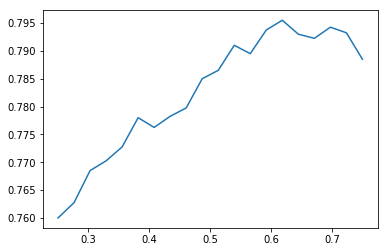

In [28]:
plt.plot(thres, thres_ioc)

In [29]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(0.61842105263157898, 0.79549999999999998)

In [30]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i] > best_thres)) for i,fn in enumerate(test_ids)}


In [31]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('outputs.csv')